## Load

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval
from tqdm.auto import tqdm
import ray
import os

np.random.seed=42

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/Users/rco/github/p_metaheuristic/data/log


In [2]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

In [3]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [4]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}

uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [5]:
uef[uef.port==1].describe()

,mean_return,var_return,port
count,2000.000000,2000.000000,2000.0
mean,0.006825,0.001579,1.0
std,0.002334,0.001116,0.0
min,0.002784,0.000642,1.0
25%,0.004804,0.000716,1.0
50%,0.006825,0.001058,1.0
75%,0.008845,0.002150,1.0
max,0.010865,0.004776,1.0


In [6]:
df_stats[df_stats.port==1].describe()

,port,i,r_mean,r_std
count,31.0,31.000000,31.000000,31.000000
mean,1.0,16.000000,0.003504,0.045723
std,0.0,9.092121,0.002186,0.007296
min,1.0,1.000000,0.000141,0.035848
25%,1.0,8.500000,0.002043,0.040043
50%,1.0,16.000000,0.003286,0.045450
75%,1.0,23.500000,0.004725,0.050112
max,1.0,31.000000,0.010865,0.069105


In [7]:
df_cov_mx[df_cov_mx.port==1].describe()

,port,i,j,cov
count,496.0,496.000000,496.000000,496.000000
mean,1.0,11.000000,21.000000,0.556209
std,0.0,7.423686,7.423686,0.178871
min,1.0,1.000000,1.000000,0.139539
25%,1.0,5.000000,16.000000,0.452670
50%,1.0,10.000000,22.000000,0.554651
75%,1.0,16.000000,27.000000,0.654551
max,1.0,31.000000,31.000000,1.000000


In [8]:
@ray.remote
def import_logs(filename):
    try:
        file_path = Path(LOG_PATH, filename)
        df = pd.read_csv(file_path, low_memory=False)
        df['filename'] = filename
        df['log_iter'] = df.index.values
        df.loc[df[-1:].index, 'last_iter'] = 1
        return df
    except:
        print(filename)


futures = [import_logs.remote(filename) for filename in os.listdir(LOG_PATH) if filename != '.DS_Store']
dfs = ray.get(futures)


(import_logs pid=44657) 
(import_logs pid=44661) 
(import_logs pid=44654) 
(import_logs pid=44652) 
(import_logs pid=44655) 


In [9]:
all_data = pd.concat(dfs, ignore_index=True)
all_data.reset_index(drop=True, inplace=True)
print(all_data.shape)
best_data = all_data[all_data.last_iter==1]
print(best_data.shape)

(932332, 19)
(9232, 19)


In [10]:
best_data.tag.value_counts()

problem_solving        7325
tuning_sigma_par       1295
tuning_iter             250
tuning_par               90
tuning_mem_size          90
tuning_mem_consider      90
tuning_sigma             90
base                      2
Name: tag, dtype: int64

In [11]:
pd.__version__

'1.4.0'

In [12]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932332 entries, 0 to 932331
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   iter          932332 non-null  int64  
 1   cost          932332 non-null  float64
 2   return        932332 non-null  float64
 3   par           932332 non-null  float64
 4   move          932332 non-null  float64
 5   X             932332 non-null  object 
 6   Z             932332 non-null  object 
 7   Q             932332 non-null  float64
 8   max_iter      932332 non-null  int64  
 9   mem_size      932332 non-null  int64  
 10  mem_consider  932332 non-null  float64
 11  sigma         932332 non-null  float64
 12  port_n        932332 non-null  int64  
 13  k             932332 non-null  int64  
 14  seed          61712 non-null   float64
 15  tag           932332 non-null  object 
 16  filename      932332 non-null  object 
 17  log_iter      932332 non-null  int64  
 18  last

In [13]:
pd.__version__

'1.4.0'

In [14]:
df_stats[df_stats.port==1]

,port,i,r_mean,r_std
0,1,1,0.001309,0.043208
1,1,2,0.004177,0.040258
2,1,3,0.001487,0.041342
3,1,4,0.004515,0.044896
4,1,5,0.010865,0.069105
5,1,6,0.001759,0.053671
6,1,7,0.002594,0.046613
7,1,8,0.004950,0.045492
8,1,9,0.007115,0.053634
9,1,10,0.003186,0.046923


In [15]:
# plt.figure(figsize=(5,8))
# plt.barh(df_stats[df_stats.port==1].i, df_stats[df_stats.port==1].r_mean)
# plt.yticks(df_stats[df_stats.port==1].i.values)
# ax=ax

In [16]:
# X_df = best_data.X.str.removeprefix('[').str.removesuffix(']').str.split(expand=True)
# X_df = X_df.astype('float32')
# new_columns = ['c_'+str(c+1).zfill(2) for c in X_df.columns]
# X_df.columns = new_columns
# X_df = pd.concat([X_df, all_data[['cost', 'risk', 'return']]], axis=1)
# X_df.head(10)

In [17]:
# for c in X_df.columns:
#     X_df[c] = X_df[c].apply(lambda x: None if x==0 else x)

## Tuning - Curvas de Aprendizado

## Fronteira de Eficiência

/var/folders/4s/j92phfsd2cn8533b6sx7q1440000gn/T/ipykernel_44514/2720197495.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename({'k':'n'}, axis=1, inplace=True)


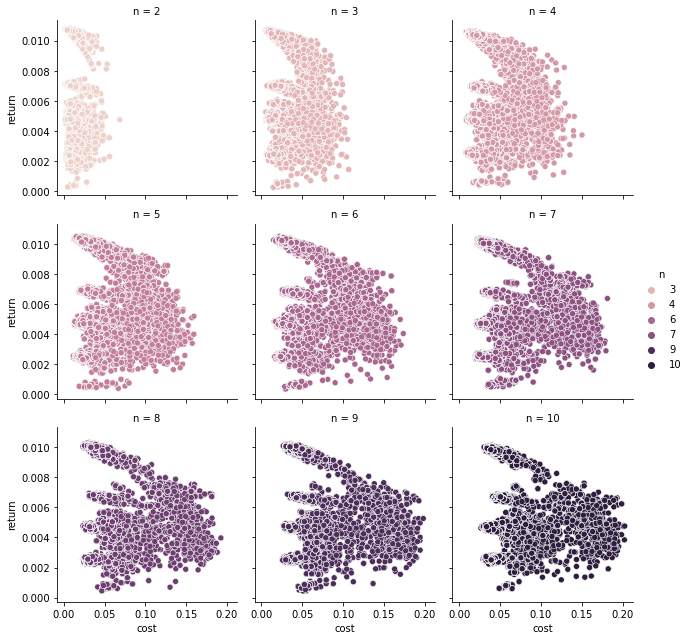

In [18]:
tag = 'problem_solving'
data = all_data[all_data.tag==tag]
data.rename({'k':'n'}, axis=1, inplace=True)
sns.relplot(data=data, x='cost', y='return', col='n', hue='n', col_wrap=3, kind='scatter', height=3)

/var/folders/4s/j92phfsd2cn8533b6sx7q1440000gn/T/ipykernel_44514/3536818319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename({'k':'n'}, axis=1, inplace=True)


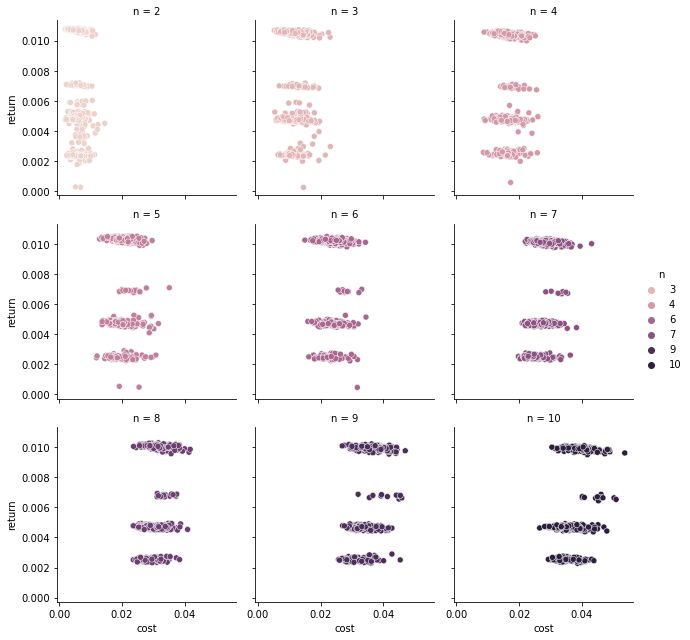

In [19]:
tag = 'problem_solving'
data = best_data[best_data.tag==tag]
data.rename({'k':'n'}, axis=1, inplace=True)
sns.relplot(data=data, x='cost', y='return', col='n', hue='n', col_wrap=3, kind='scatter', height=3)

/var/folders/4s/j92phfsd2cn8533b6sx7q1440000gn/T/ipykernel_44514/357892109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename({'k':'n'}, axis=1, inplace=True)


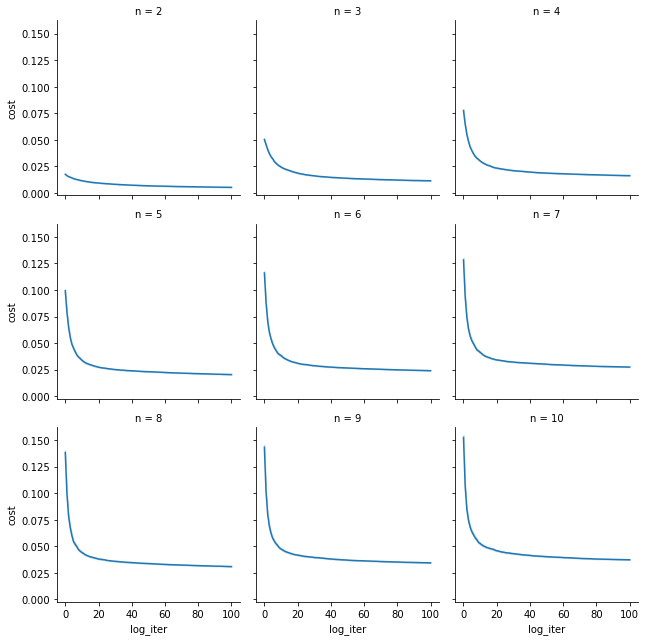

In [20]:
tag = 'problem_solving'
data = all_data[all_data.tag==tag]
data.rename({'k':'n'}, axis=1, inplace=True)
sns.relplot(data=data, x='log_iter', y='cost', col='n', col_wrap=3, kind='line', height=3)

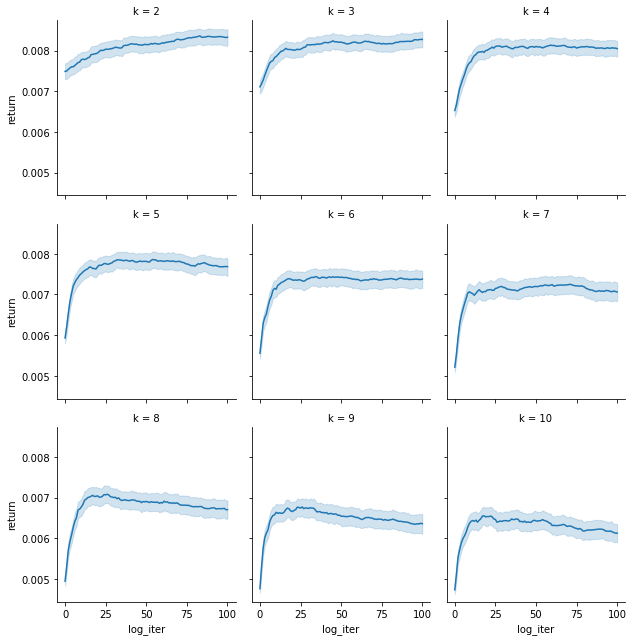

In [21]:
tag = 'problem_solving'
data = all_data[all_data.tag==tag]
sns.relplot(data=data, x='log_iter', y='return', col='k', col_wrap=3, kind='line', height=3)

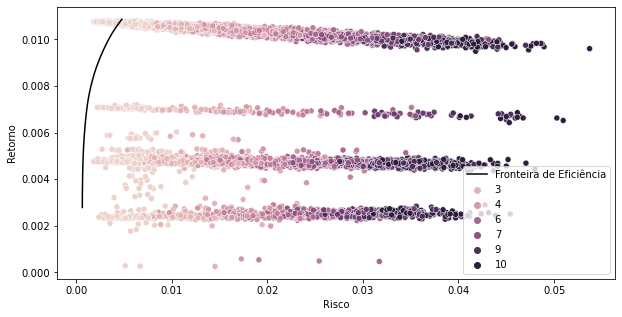

In [22]:
tag = 'problem_solving'
data = best_data[best_data.tag==tag]
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.scatterplot(data=data, x='cost', y='return', hue='k')
plt.ylabel("Retorno")
plt.xlabel("Risco")
plt.legend()

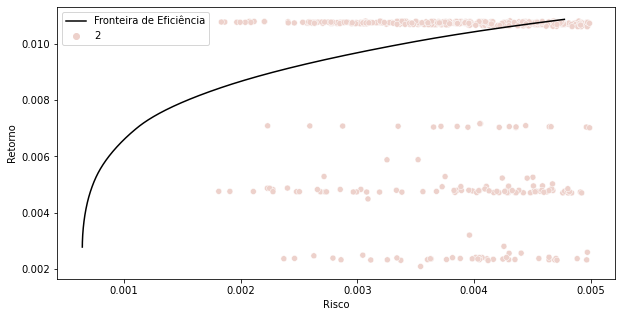

In [23]:
tag = 'problem_solving'
data = best_data[(best_data.tag==tag) & (best_data.cost<=0.005)] 
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.scatterplot(data=data, x='cost', y='return', hue='k')
plt.ylabel("Retorno")
plt.xlabel("Risco")
plt.legend()

In [24]:
cef = []
tag = 'problem_solving'
for k in tqdm(best_data.k.unique()):
    data = best_data[(best_data.tag==tag) & (best_data.k==k)]
    for i in tqdm(data.index.values):
        cond1 = data[data.index!=i]['return'] > data.loc[i, 'return']
        cond2 = data[data.index!=i]['cost'] <= data.loc[i, 'cost']
        cond3 = data[data.index!=i]['return'] >= data.loc[i, 'return']
        cond4 = data[data.index!=i]['cost'] < data.loc[i, 'cost']
        if (not any(cond1 & cond2)) | (not any(cond3 & cond4)):
            cef.append(i)

100%|██████████| 9/9 [00:13<00:00,  1.53s/it]


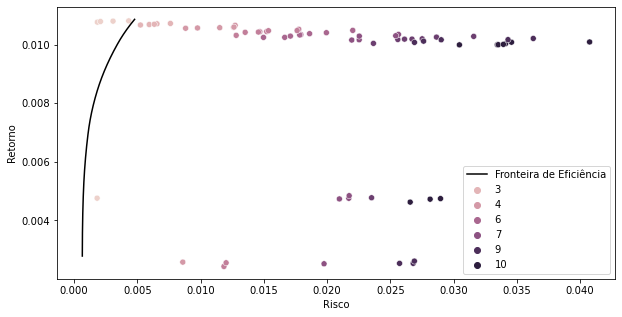

In [25]:
data = all_data.loc[cef]
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.scatterplot(data=data, x='cost', y='return', hue='k')
plt.ylabel("Retorno")
plt.xlabel("Risco")
plt.legend()

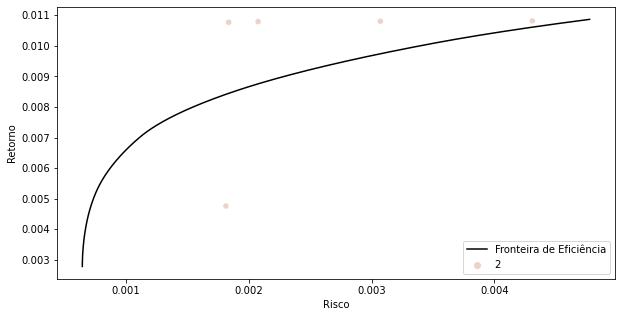

In [54]:
data = all_data.loc[cef]
data = data[data.cost<=0.005]
top_solutions = data.filename.values
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.scatterplot(data=data, x='cost', y='return', hue='k')
plt.ylabel("Retorno")
plt.xlabel("Risco")
plt.legend(loc='lower right')

In [66]:
def get_X(df, targets=None):
    X_df = df.X.str.removeprefix('[').str.removesuffix(']').str.split(expand=True)
    X_df = X_df.astype('float32')
    new_columns = ['a_'+str(c+1).zfill(2) for c in X_df.columns]
    X_df.columns = new_columns
    X_df = X_df.applymap(lambda x: np.NaN if x==0 else x)
    # X_df.index=df.log_iter.values
    if targets is not None:
        X_df = pd.concat([X_df, df[targets]], axis=1)

    return X_df

In [70]:
df2 = get_X(best_data[best_data.filename.isin(top_solutions)], ['cost', 'return', 'filename'])
df2
# df2.to_csv('export.csv')

,a_01,a_02,a_03,a_04,a_05,a_06,a_07,a_08,a_09,a_10,a_11,a_12,a_13,a_14,a_15,a_16,a_17,a_18,a_19,a_20,a_21,a_22,a_23,a_24,a_25,a_26,a_27,a_28,a_29,a_30,a_31,cost,return,filename
51303,NaN,NaN,NaN,NaN,0.986191,NaN,NaN,NaN,0.013809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004309,0.010813,log_hs_problem_solving_20220128_162327_330028.csv
404264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.986840,NaN,0.013160,NaN,NaN,NaN,0.001812,0.004761,log_hs_problem_solving_20220128_162607_762713.csv
449104,NaN,NaN,NaN,NaN,0.988904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011096,NaN,NaN,NaN,0.001835,0.010770,log_hs_problem_solving_20220128_163342_699532.csv
473948,NaN,NaN,NaN,NaN,0.987964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012036,NaN,NaN,NaN,NaN,NaN,0.002074,0.010792,log_hs_problem_solving_20220128_162357_893308.csv
518788,NaN,NaN,NaN,NaN,0.988011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011989,NaN,NaN,0.003070,0.010804,log_hs_problem_solving_20220128_163542_754826.csv


<AxesSubplot:>

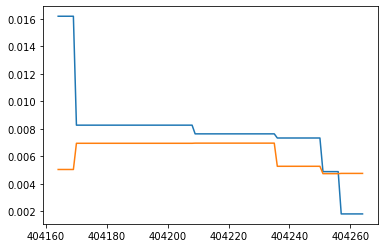

In [ ]:
all_data[all_data.filename=='log_hs_problem_solving_20220128_162607_762713.csv'].cost.plot()
all_data[all_data.filename=='log_hs_problem_solving_20220128_162607_762713.csv']['return'].plot()


In [ ]:
all_data[(all_data.filename=='log_hs_problem_solving_20220128_162607_762713.csv')].head().X.str.split(expand=True)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
404164,[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.91601223,0.,0.,0.,0.,0.,0.,0.,0.,0.08398777,0.,0.,0.,]
404165,[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.91601223,0.,0.,0.,0.,0.,0.,0.,0.,0.08398777,0.,0.,0.,]
404166,[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.91601223,0.,0.,0.,0.,0.,0.,0.,0.,0.08398777,0.,0.,0.,]
404167,[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.91601223,0.,0.,0.,0.,0.,0.,0.,0.,0.08398777,0.,0.,0.,]
404168,[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.91601223,0.,0.,0.,0.,0.,0.,0.,0.,0.08398777,0.,0.,0.,]


In [ ]:
all_data[(all_data.filename=='log_hs_problem_solving_20220128_162607_762713.csv')].tail().X.str.split(expand=True)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
404260,[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.98683974,0.,0.01316026,0.,0.,0.,]
404261,[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.98683974,0.,0.01316026,0.,0.,0.,]
404262,[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.98683974,0.,0.01316026,0.,0.,0.,]
404263,[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.98683974,0.,0.01316026,0.,0.,0.,]
404264,[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.98683974,0.,0.01316026,0.,0.,0.,]


In [32]:
data = get_X(all_data[(all_data.filename=='log_hs_problem_solving_20220128_162607_762713.csv')])
data.head()

,c_01,c_02,c_03,c_04,c_05,c_06,c_07,c_08,c_09,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.916012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083988,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.916012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083988,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.916012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083988,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.916012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083988,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.916012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083988,NaN,NaN,NaN


In [89]:
df_stats[df_stats.port==1].describe()

,port,i,r_mean,r_std
count,31.0,31.000000,31.000000,31.000000
mean,1.0,16.000000,0.003504,0.045723
std,0.0,9.092121,0.002186,0.007296
min,1.0,1.000000,0.000141,0.035848
25%,1.0,8.500000,0.002043,0.040043
50%,1.0,16.000000,0.003286,0.045450
75%,1.0,23.500000,0.004725,0.050112
max,1.0,31.000000,0.010865,0.069105


In [ ]:
uef[uef.port==1].describe()

,mean_return,var_return,port
count,2000.000000,2000.000000,2000.0
mean,0.006825,0.001579,1.0
std,0.002334,0.001116,0.0
min,0.002784,0.000642,1.0
25%,0.004804,0.000716,1.0
50%,0.006825,0.001058,1.0
75%,0.008845,0.002150,1.0
max,0.010865,0.004776,1.0


In [90]:
df_cov_mx[df_cov_mx.port==1].describe()

,port,i,j,cov
count,496.0,496.000000,496.000000,496.000000
mean,1.0,11.000000,21.000000,0.556209
std,0.0,7.423686,7.423686,0.178871
min,1.0,1.000000,1.000000,0.139539
25%,1.0,5.000000,16.000000,0.452670
50%,1.0,10.000000,22.000000,0.554651
75%,1.0,16.000000,27.000000,0.654551
max,1.0,31.000000,31.000000,1.000000


In [79]:
df_cov_mx[(df_cov_mx.i==5) & (df_cov_mx.j==9)]

,port,i,j,cov
122,1,5,9,0.316438
338,2,5,9,0.494749
354,3,5,9,0.210999
390,4,5,9,0.170637
898,5,5,9,0.360093


In [81]:
df_stats[(df_stats.port==1)&(df_stats.i.isin([5,9]))]

,port,i,r_mean,r_std
4,1,5,0.010865,0.069105
8,1,9,0.007115,0.053634


In [75]:
0.316438 * 0.99 * 0.01

0.0031327361999999997

In [88]:
(0.010865 * 0.99) + (0.007115 * 0.01)

0.0108275

In [82]:
0.316438 * 0.99 * 0.01 * 0.069105 * 0.053634

1.1611103184407033e-05

In [76]:
0.99 * 0.01

0.0099

In [77]:
0.5 * 0.5

0.25

<AxesSubplot:>

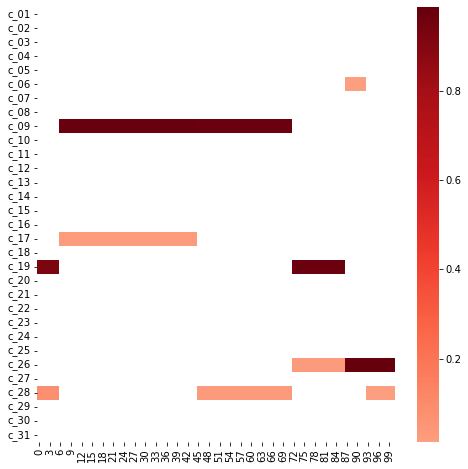

In [48]:
plt.figure(figsize=(8,8))
sns.heatmap(data=data.T, cmap='Reds', center=0.25)

<AxesSubplot:>

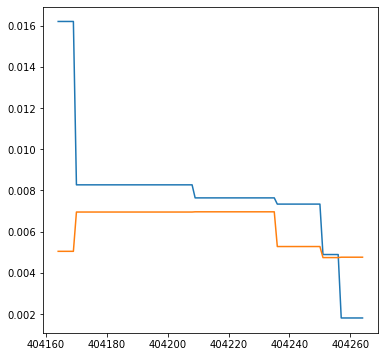

In [52]:
all_data[all_data.filename=='log_hs_problem_solving_20220128_162607_762713.csv'].cost.plot(figsize=(6,6))
all_data[all_data.filename=='log_hs_problem_solving_20220128_162607_762713.csv']['return'].plot()


<AxesSubplot:>

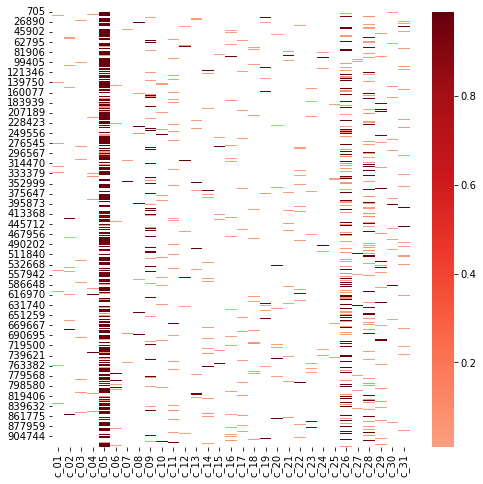

In [38]:
plt.figure(figsize=(8,8))
tag='problem_solving'
k=2
sns.heatmap(data=get_X(all_data[(all_data.tag==tag)&(all_data.k==k)]), cmap='Reds', center=0.25)

<AxesSubplot:>

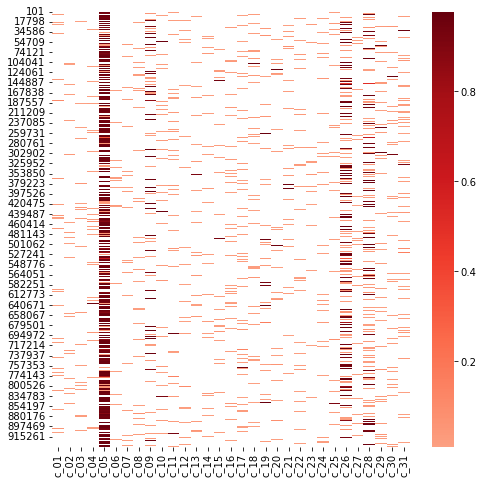

In [39]:
plt.figure(figsize=(8,8))
tag='problem_solving'
k=3
sns.heatmap(data=get_X(all_data[(all_data.tag==tag)&(all_data.k==k)]), cmap='Reds', center=0.25)

<AxesSubplot:>

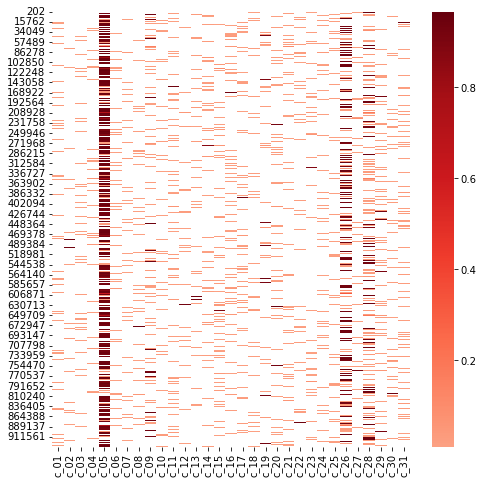

In [40]:
plt.figure(figsize=(8,8))
tag='problem_solving'
k=4
sns.heatmap(data=get_X(all_data[(all_data.tag==tag)&(all_data.k==k)]), cmap='Reds', center=0.25)

<AxesSubplot:>

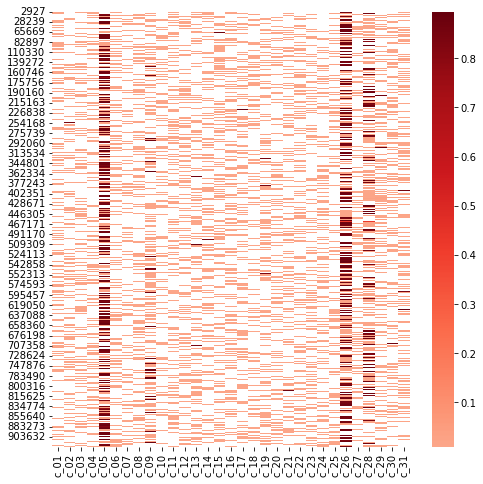

In [41]:
plt.figure(figsize=(8,8))
tag='problem_solving'
k=10
sns.heatmap(data=get_X(all_data[(all_data.tag==tag)&(all_data.k==k)]), cmap='Reds', center=0.25)

<AxesSubplot:>

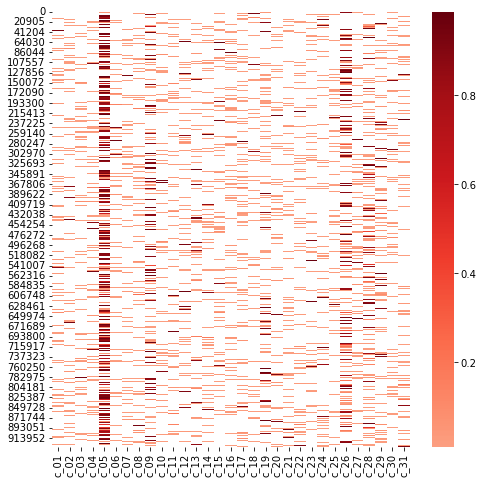

In [43]:
plt.figure(figsize=(8,8))
tag='problem_solving'
sns.heatmap(data=get_X(all_data[(all_data.tag==tag)&(all_data.log_iter==0)]), cmap='Reds', center=0.25)

In [46]:
df_stats[df_stats.port==1].sort_values('r_mean', ascending=False).head()

,port,i,r_mean,r_std
4,1,5,0.010865,0.069105
8,1,9,0.007115,0.053634
28,1,29,0.005817,0.035848
18,1,19,0.005294,0.058710
11,1,12,0.005202,0.042955


In [47]:
df_stats[df_stats.port==1].sort_values('r_std', ascending=True).head()

,port,i,r_mean,r_std
28,1,29,0.005817,0.035848
27,1,28,0.002338,0.036047
14,1,15,0.003960,0.036183
29,1,30,0.001993,0.036762
21,1,22,0.001879,0.038128


In [ ]:
# X_df = all_data.X.str.removeprefix('[').str.removesuffix(']').str.split(expand=True)
# X_df = X_df.astype('float32')
# new_columns = ['c_'+str(c+1).zfill(2) for c in X_df.columns]
# X_df.columns = new_columns
# X_df = pd.concat([X_df, all_data[['cost', 'risk', 'return']]], axis=1)
# X_df.head()
# def plot_correlation(target):
#     corr = X_df.drop([c for c in ['cost', 'risk', 'return'] if c !=target], axis=1).corr()
#     plt.figure(figsize=(12,12))
#     ax = sns.heatmap(
#         corr.iloc[-1:,:-1],
#         vmin=-1, vmax=1, center=0,
#         cmap=sns.diverging_palette(20, 220, n=200),
#         square=True,
#         cbar_kws={"orientation": "horizontal"}  
#     )
#     ax.set_xticklabels(
#         ax.get_xticklabels(),
#         rotation=45,
#         horizontalalignment='right'
#     )
#     ax=ax
# plot_correlation('cost')
# plot_correlation('risk')
# plot_correlation('return')


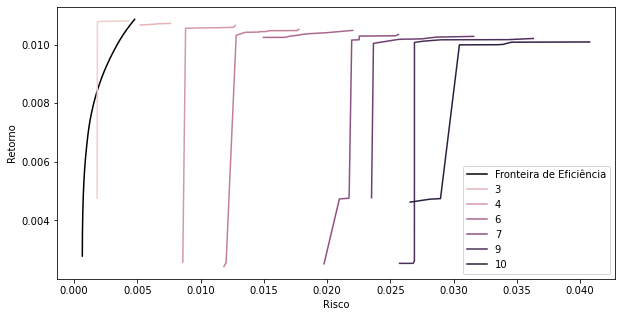

In [ ]:
data = all_data.loc[cef]
plt.figure(figsize=(10,5))
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return, color='k', label='Fronteira de Eficiência')
# plt.scatter(data.obj, data['return'], alpha=0.5, c=data.Q, label='Melhores Resultados')
sns.lineplot(data=data, x='cost', y='return', hue='k')
plt.ylabel("Retorno")
plt.xlabel("Risco")
plt.legend()